In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pathlib
import random
from sklearn.metrics import confusion_matrix, classification_report



2025-04-28 14:18:47.076260: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-04-28 14:18:47.076318: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# SETTING HYPERPARAMETERS

In [2]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configuration parameters
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 2  # Binary classification (human or no human)
EPOCHS = 15
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2
DATA_DIR = "./human detection dataset"  # Path to your dataset


# DATASET HELPER FUNCTIONS

In [3]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
])

def preprocess_image(image_path, label):
    """Load and preprocess a single image."""
    # Read image file
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    
    # Convert image to float and normalize to [0, 1]
    img = tf.cast(img, tf.float32) / 255.0
    
    # Resize
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    
    # One-hot encode the label
    label = tf.one_hot(label, NUM_CLASSES)
    
    return img, label

def create_dataset(image_paths, labels, is_training=False):
    """Create a TensorFlow dataset from image paths and labels."""
    # Create dataset from paths and labels
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # Load and preprocess images
    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Apply data augmentation if training
    if is_training:
        ds = ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batch and prefetch
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    return ds



class_0_dir = os.path.join(DATA_DIR, "0" )
class_1_dir = os.path.join(DATA_DIR, "1" ) 

# Count files in each class
class_0_files = os.listdir(class_0_dir)
class_1_files = os.listdir(class_1_dir)

print(f"Found {len(class_0_files)} images without humans")
print(f"Found {len(class_1_files)} images with humans")

# Create image paths and labels lists
image_paths = []
labels = []

# generate file path
for file_path in class_0_files:
    image_paths.append(str(os.path.join(DATA_DIR, "0", file_path)))
    labels.append(0)

for file_path in class_1_files:
    image_paths.append(str(os.path.join(DATA_DIR, "1", file_path)))
    labels.append(1)

# Shuffle the data
temp = list(zip(image_paths, labels))
random.shuffle(temp)
image_paths, labels = zip(*temp)

labels = np.array(labels)

# Split into train and validation sets
total_size = len(image_paths)
val_size = int(total_size * VALIDATION_SPLIT)
train_size = total_size - val_size

train_paths = image_paths[:train_size]
train_labels = labels[:train_size]
val_paths = image_paths[train_size:]
val_labels = labels[train_size:]

print(f"Training set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")


train_paths = list(train_paths)
val_paths = list(val_paths)

# Create TensorFlow datasets
train_ds = create_dataset(train_paths, train_labels, is_training=True)
val_ds = create_dataset(val_paths, val_labels, is_training=False)




2025-04-28 14:18:52.608808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 14:18:52.609089: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-04-28 14:18:52.609468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2025-04-28 14:18:52.609606: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2025-04-28 14:18:52.609936: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Found 362 images without humans
Found 559 images with humans
Training set: 737 images
Validation set: 184 images


# BUILD MOBILENET V2 MODEL

In [4]:
def build_mobilenetv2_model():
    """Build model using TensorFlow's pre-implemented MobileNetV2."""
    print("Building MobileNetV2 model for human detection...")
    
    # Create the base model from the pre-trained MobileNetV2
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # First, freeze the base model
    base_model.trainable = False
    
    # Create new model on top
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs, name='MobileNetV2_HumanDetection')
    
    return model, base_model

def unfreeze_model(model, base_model):
    """Unfreeze the base model for fine-tuning."""
    # Unfreeze the base model
    base_model.trainable = True
    
    # Freeze the first 100 layers (early layers)
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Recompile the model with a lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model




# TRAIN THE MODEL

In [5]:
def train_model(model, train_ds, val_ds, base_model):
    """Train the model in two phases: feature extraction and fine-tuning."""
    print("Training the model - Phase 1: Feature Extraction...")
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Define callbacks for phase 1
    callbacks_phase1 = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath='mobilenetv2_human_detection_phase1.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        )
    ]
    
    # Phase 1: Train with frozen base model (feature extraction)
    history1 = model.fit(
        train_ds,
        epochs=5,  # Fewer epochs for initial phase
        validation_data=val_ds,
        callbacks=callbacks_phase1
    )
    
    print("\nTraining the model - Phase 2: Fine-tuning...")
    
    # Phase 2: Fine-tuning - unfreeze the model and train with a lower learning rate
    model = unfreeze_model(model, base_model)
    
    # Define callbacks for phase 2
    callbacks_phase2 = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath='mobilenetv2_human_detection_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )
    ]
    
    # Phase 2: Train with unfrozen base model (fine-tuning)
    history2 = model.fit(
        train_ds,
        epochs=EPOCHS-5,  # Remaining epochs for fine-tuning
        validation_data=val_ds,
        callbacks=callbacks_phase2
    )
    
    # Combine histories
    combined_history = {}
    for k in history1.history.keys():
        combined_history[k] = history1.history[k] + history2.history[k]
    
    return tf.keras.callbacks.History(), combined_history

In [6]:
def plot_training_history(history):
    """Plot the training and validation accuracy and loss."""
    print("Plotting training history...")
    
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.savefig('mobilenetv2_human_detection_training_history.png')
    plt.show()

def visualize_activations(model, val_ds):
    """Visualize intermediate activations to see what the model focuses on."""
    # Get an image from the validation set
    for images, labels in val_ds.take(1):
        sample_image = images[0]
        sample_label = np.argmax(labels[0])
        break
    
    # Create a modified model that outputs intermediate activations
    layer_outputs = [layer.output for layer in model.layers[1].layers[50:60]]  # Get some intermediate layer outputs
    activation_model = tf.keras.Model(inputs=model.layers[1].input, outputs=layer_outputs)
    
    # Get activations
    activations = activation_model(tf.expand_dims(sample_image, 0))
    
    # Display the original image
    plt.figure(figsize=(12, 12))
    plt.subplot(3, 4, 1)
    
    # Convert from preprocessing format back to display format
    display_image = sample_image.numpy()
    display_image = ((display_image * 0.5) + 0.5) * 255  # Reverse preprocessing
    display_image = np.clip(display_image, 0, 255).astype('uint8')
    
    plt.imshow(display_image)
    plt.title(f"Original Image (Class: {'Human' if sample_label == 1 else 'No Human'})")
    plt.axis('off')
    
    # Display some activation maps
    for i, activation in enumerate(activations[:9]):
        plt.subplot(3, 4, i+2)
        plt.imshow(activation[0, :, :, 0], cmap='viridis')
        plt.title(f"Activation {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('mobilenetv2_human_detection_activations.png')
    plt.show()

def evaluate_model(model, val_ds):
    """Evaluate the model on validation data."""
    print("Evaluating the model...")
    
    # Evaluate on the validation set
    val_loss, val_accuracy = model.evaluate(val_ds)
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print(f"Validation loss: {val_loss:.4f}")
    
    # Get a batch of validation data
    all_images = []
    all_labels = []
    all_predictions = []
    
    # Collect predictions on the validation set
    for images, labels in val_ds:
        predictions = model.predict(images)
        all_images.extend(images.numpy())
        all_labels.extend(np.argmax(labels.numpy(), axis=1))
        all_predictions.extend(np.argmax(predictions, axis=1))
    
    # Convert lists to numpy arrays
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    
    # Plot some predictions
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(all_images))):
        plt.subplot(3, 3, i+1)
        
        # Convert from preprocessing format back to display format
        display_image = all_images[i]
        display_image = ((display_image * 0.5) + 0.5) * 255  # Reverse preprocessing
        display_image = np.clip(display_image, 0, 255).astype('uint8')
        
        plt.imshow(display_image)
        color = 'green' if all_predictions[i] == all_labels[i] else 'red'
        title = f"Pred: {'Human' if all_predictions[i] == 1 else 'No Human'}\nTrue: {'Human' if all_labels[i] == 1 else 'No Human'}"
        plt.title(title, color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('mobilenetv2_human_detection_predictions.png')
    plt.show()
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(NUM_CLASSES)
    plt.xticks(tick_marks, ['No Human', 'Human'], rotation=45)
    plt.yticks(tick_marks, ['No Human', 'Human'])
    
    # Add text annotations to confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('mobilenetv2_human_detection_confusion_matrix.png')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=['No Human', 'Human']))


Building MobileNetV2 model for human detection...
Model: "MobileNetV2_HumanDetection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                        

2025-04-28 14:18:57.366788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:18:57.444978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/24 [>.............................] - ETA: 1:09 - loss: 0.9351 - accuracy: 0.5000

2025-04-28 14:18:57.815996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:18:58.073757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/24 [=>............................] - ETA: 7s - loss: 0.8751 - accuracy: 0.5000  

2025-04-28 14:18:58.400068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:18:58.423006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/24 [==>...........................] - ETA: 7s - loss: 0.9420 - accuracy: 0.5208

2025-04-28 14:18:58.797899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/24 [======>.......................] - ETA: 6s - loss: 0.9832 - accuracy: 0.5104

2025-04-28 14:18:59.880255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/24 [=======>......................] - ETA: 5s - loss: 0.9846 - accuracy: 0.5045

2025-04-28 14:19:00.113302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/24 [=========>....................] - ETA: 5s - loss: 0.9207 - accuracy: 0.5391

2025-04-28 14:19:00.405942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:00.422356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/24 [==========>...................] - ETA: 4s - loss: 0.8943 - accuracy: 0.5556

2025-04-28 14:19:00.663808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/24 [============>.................] - ETA: 4s - loss: 0.8799 - accuracy: 0.5682

2025-04-28 14:19:01.049042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:01.169947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:01.175161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:01.176795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/24 [==============>...............] - ETA: 3s - loss: 0.8480 - accuracy: 0.5781

2025-04-28 14:19:01.527320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:01.533922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/24 [================>.............] - ETA: 3s - loss: 0.8546 - accuracy: 0.5781

2025-04-28 14:19:01.802739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/24 [===========================>..] - ETA: 0s - loss: 0.7683 - accuracy: 0.6291

2025-04-28 14:19:04.791674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:04.801515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:04.846616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:04.886753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:04.909298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:04.939197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:04.989805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 00001: val_accuracy improved from -inf to 0.76630, saving model to mobilenetv2_human_detection_phase1.h5
24/24 [==============================] - 12s 371ms/step - loss: 0.7676 - accuracy: 0.6296 - val_loss: 0.4648 - val_accuracy: 0.7663


/home/testtube_v/miniconda3/envs/raspi/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 2/5


2025-04-28 14:19:06.677953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:06.700606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/24 [>.............................] - ETA: 8s - loss: 0.6871 - accuracy: 0.5625

2025-04-28 14:19:06.930746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/24 [=>............................] - ETA: 6s - loss: 0.5587 - accuracy: 0.7031

2025-04-28 14:19:07.172010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/24 [==>...........................] - ETA: 5s - loss: 0.5469 - accuracy: 0.7292

2025-04-28 14:19:07.413646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:07.417235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:07.687735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/24 [=======>......................] - ETA: 4s - loss: 0.4818 - accuracy: 0.7723

2025-04-28 14:19:08.632346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:08.821194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/24 [=========>....................] - ETA: 4s - loss: 0.4787 - accuracy: 0.7695

2025-04-28 14:19:09.048997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:09.073519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/24 [==========>...................] - ETA: 4s - loss: 0.4717 - accuracy: 0.7778

2025-04-28 14:19:09.321946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/24 [============>.................] - ETA: 3s - loss: 0.4755 - accuracy: 0.7756

2025-04-28 14:19:09.692791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:09.792292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:09.800240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:09.806039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/24 [===============>..............] - ETA: 3s - loss: 0.4795 - accuracy: 0.7668

2025-04-28 14:19:10.234690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:10.244340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/24 [================>.............] - ETA: 2s - loss: 0.4766 - accuracy: 0.7746

2025-04-28 14:19:10.469802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/24 [===========================>..] - ETA: 0s - loss: 0.4775 - accuracy: 0.7772

2025-04-28 14:19:12.976454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:12.979824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:13.020569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:13.056409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:13.067558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:13.084520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:13.114739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 00002: val_accuracy improved from 0.76630 to 0.80435, saving model to mobilenetv2_human_detection_phase1.h5
24/24 [==============================] - 8s 347ms/step - loss: 0.4769 - accuracy: 0.7775 - val_loss: 0.4317 - val_accuracy: 0.8043
Epoch 3/5


2025-04-28 14:19:15.221481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:15.246448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/24 [>.............................] - ETA: 9s - loss: 0.4564 - accuracy: 0.7812

2025-04-28 14:19:15.505276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:15.771195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/24 [=>............................] - ETA: 8s - loss: 0.4653 - accuracy: 0.7969

2025-04-28 14:19:16.100695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:16.100784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/24 [====>.........................] - ETA: 6s - loss: 0.4518 - accuracy: 0.7969

2025-04-28 14:19:16.419747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/24 [=======>......................] - ETA: 5s - loss: 0.4287 - accuracy: 0.8036

2025-04-28 14:19:17.418777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:17.605674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/24 [=========>....................] - ETA: 5s - loss: 0.4365 - accuracy: 0.7969

2025-04-28 14:19:17.925938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:17.946578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/24 [==========>...................] - ETA: 4s - loss: 0.4349 - accuracy: 0.7986

2025-04-28 14:19:18.236529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/24 [============>.................] - ETA: 4s - loss: 0.4289 - accuracy: 0.8011

2025-04-28 14:19:18.610966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:18.787984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:18.788144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:18.789086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/24 [===============>..............] - ETA: 3s - loss: 0.4303 - accuracy: 0.7981

2025-04-28 14:19:19.187092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:19.189998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:19.428955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/24 [===========================>..] - ETA: 0s - loss: 0.4296 - accuracy: 0.8098

2025-04-28 14:19:22.006931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:22.009327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:22.041060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:22.080844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:22.087287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:22.107432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:22.140735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 00003: val_accuracy improved from 0.80435 to 0.82609, saving model to mobilenetv2_human_detection_phase1.h5
24/24 [==============================] - 9s 362ms/step - loss: 0.4294 - accuracy: 0.8100 - val_loss: 0.3820 - val_accuracy: 0.8261
Epoch 4/5


2025-04-28 14:19:24.142835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:24.158945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/24 [>.............................] - ETA: 8s - loss: 0.4951 - accuracy: 0.7188

2025-04-28 14:19:24.394936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/24 [=>............................] - ETA: 6s - loss: 0.4985 - accuracy: 0.7500

2025-04-28 14:19:24.644799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:24.918655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:24.923444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/24 [==>...........................] - ETA: 7s - loss: 0.4864 - accuracy: 0.7604

2025-04-28 14:19:25.267761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/24 [=======>......................] - ETA: 5s - loss: 0.4381 - accuracy: 0.7991

2025-04-28 14:19:26.185224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:26.367311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/24 [=========>....................] - ETA: 4s - loss: 0.4397 - accuracy: 0.8008

2025-04-28 14:19:26.658689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:26.665710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/24 [==========>...................] - ETA: 4s - loss: 0.4247 - accuracy: 0.8090

2025-04-28 14:19:26.962805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/24 [============>.................] - ETA: 4s - loss: 0.4048 - accuracy: 0.8125

2025-04-28 14:19:27.474734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:27.621448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:27.637057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:27.641424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/24 [===============>..............] - ETA: 3s - loss: 0.4034 - accuracy: 0.8221

2025-04-28 14:19:28.037377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:28.043652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/24 [================>.............] - ETA: 3s - loss: 0.4151 - accuracy: 0.8125

2025-04-28 14:19:28.313376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/24 [===========================>..] - ETA: 0s - loss: 0.4067 - accuracy: 0.8166

2025-04-28 14:19:30.919473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:30.925307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:30.952996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:30.990615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:31.010301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:31.030028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:31.061318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 00004: val_accuracy did not improve from 0.82609
24/24 [==============================] - 8s 344ms/step - loss: 0.4062 - accuracy: 0.8168 - val_loss: 0.3936 - val_accuracy: 0.8207
Epoch 5/5


2025-04-28 14:19:32.615571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:32.635673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/24 [>.............................] - ETA: 10s - loss: 0.4087 - accuracy: 0.8125

2025-04-28 14:19:32.898350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:33.180594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/24 [=>............................] - ETA: 7s - loss: 0.3917 - accuracy: 0.8125 

2025-04-28 14:19:33.443008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:33.546549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/24 [==>...........................] - ETA: 7s - loss: 0.4162 - accuracy: 0.7917

2025-04-28 14:19:33.940768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/24 [======>.......................] - ETA: 6s - loss: 0.3725 - accuracy: 0.8229

2025-04-28 14:19:34.923486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/24 [=======>......................] - ETA: 5s - loss: 0.3658 - accuracy: 0.8393

2025-04-28 14:19:35.156470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/24 [=========>....................] - ETA: 5s - loss: 0.3656 - accuracy: 0.8398

2025-04-28 14:19:35.455238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:35.461428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/24 [==========>...................] - ETA: 4s - loss: 0.3663 - accuracy: 0.8299

2025-04-28 14:19:35.743363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/24 [============>.................] - ETA: 4s - loss: 0.3711 - accuracy: 0.8295

2025-04-28 14:19:36.169702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:36.328791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:36.339797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:36.341109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/24 [===============>..............] - ETA: 3s - loss: 0.3761 - accuracy: 0.8269

2025-04-28 14:19:36.712920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:36.713081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/24 [================>.............] - ETA: 3s - loss: 0.3721 - accuracy: 0.8326

2025-04-28 14:19:36.982311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/24 [===========================>..] - ETA: 0s - loss: 0.3937 - accuracy: 0.8274

2025-04-28 14:19:39.597105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:39.600905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:39.625380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:39.655966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:39.668282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:39.686916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:39.712033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 00005: val_accuracy improved from 0.82609 to 0.83696, saving model to mobilenetv2_human_detection_phase1.h5
24/24 [==============================] - 9s 357ms/step - loss: 0.3932 - accuracy: 0.8277 - val_loss: 0.3640 - val_accuracy: 0.8370

Training the model - Phase 2: Fine-tuning...
Epoch 1/10


2025-04-28 14:19:44.013883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:44.032000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:44.283147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/24 [>.............................] - ETA: 1:09 - loss: 0.3562 - accuracy: 0.8438

2025-04-28 14:19:44.504539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/24 [=>............................] - ETA: 9s - loss: 0.3372 - accuracy: 0.8594  

2025-04-28 14:19:45.086187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:45.099986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/24 [==>...........................] - ETA: 8s - loss: 0.3670 - accuracy: 0.8646

2025-04-28 14:19:45.484783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/24 [======>.......................] - ETA: 7s - loss: 0.3633 - accuracy: 0.8698

2025-04-28 14:19:46.868210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/24 [=======>......................] - ETA: 7s - loss: 0.3571 - accuracy: 0.8661

2025-04-28 14:19:47.195028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/24 [=========>....................] - ETA: 6s - loss: 0.3715 - accuracy: 0.8555

2025-04-28 14:19:47.564754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:47.564942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/24 [==========>...................] - ETA: 6s - loss: 0.3529 - accuracy: 0.8646

2025-04-28 14:19:47.952652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/24 [===========>..................] - ETA: 5s - loss: 0.3573 - accuracy: 0.8594

2025-04-28 14:19:48.388193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/24 [============>.................] - ETA: 5s - loss: 0.3445 - accuracy: 0.8693

2025-04-28 14:19:48.720904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:48.738832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:48.909782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/24 [==============>...............] - ETA: 4s - loss: 0.3423 - accuracy: 0.8724

2025-04-28 14:19:49.134257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:49.159573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/24 [===============>..............] - ETA: 4s - loss: 0.3490 - accuracy: 0.8750

2025-04-28 14:19:49.625912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/24 [===========================>..] - ETA: 0s - loss: 0.3611 - accuracy: 0.8614

2025-04-28 14:19:53.943505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:53.945648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:53.967744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:53.997853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:54.008397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:54.024439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:54.050584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 00001: val_accuracy improved from -inf to 0.83696, saving model to mobilenetv2_human_detection_best.h5
24/24 [==============================] - 14s 476ms/step - loss: 0.3606 - accuracy: 0.8616 - val_loss: 0.3407 - val_accuracy: 0.8370 - lr: 1.0000e-05
Epoch 2/10


2025-04-28 14:19:55.679919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:55.702223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:55.963138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:56.150637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/24 [=>............................] - ETA: 8s - loss: 0.3272 - accuracy: 0.8750 

2025-04-28 14:19:56.605089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:56.612104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/24 [==>...........................] - ETA: 8s - loss: 0.3179 - accuracy: 0.8750

2025-04-28 14:19:57.055090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/24 [======>.......................] - ETA: 7s - loss: 0.2701 - accuracy: 0.8854

2025-04-28 14:19:58.256039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/24 [=======>......................] - ETA: 6s - loss: 0.2693 - accuracy: 0.8795

2025-04-28 14:19:58.592073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/24 [=========>....................] - ETA: 6s - loss: 0.2803 - accuracy: 0.8672

2025-04-28 14:19:58.987381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:19:58.994870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/24 [==========>...................] - ETA: 5s - loss: 0.2803 - accuracy: 0.8715

2025-04-28 14:19:59.379348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/24 [===========>..................] - ETA: 5s - loss: 0.2809 - accuracy: 0.8687

2025-04-28 14:19:59.796971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/24 [============>.................] - ETA: 5s - loss: 0.2766 - accuracy: 0.8722

2025-04-28 14:20:00.137768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:00.144605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:00.145178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/24 [==============>...............] - ETA: 4s - loss: 0.2764 - accuracy: 0.8724

2025-04-28 14:20:00.525155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:00.558691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/24 [===============>..............] - ETA: 4s - loss: 0.2889 - accuracy: 0.8678

2025-04-28 14:20:01.000501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/24 [===========================>..] - ETA: 0s - loss: 0.2979 - accuracy: 0.8777

2025-04-28 14:20:04.565787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:04.567977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:04.587075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:04.618127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:04.628788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:04.641018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:04.666474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 00002: val_accuracy improved from 0.83696 to 0.84239, saving model to mobilenetv2_human_detection_best.h5
24/24 [==============================] - 11s 455ms/step - loss: 0.2976 - accuracy: 0.8779 - val_loss: 0.3396 - val_accuracy: 0.8424 - lr: 1.0000e-05
Epoch 3/10


2025-04-28 14:20:06.795437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:06.821411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:07.050339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/24 [>.............................] - ETA: 13s - loss: 0.3856 - accuracy: 0.9062

2025-04-28 14:20:07.265576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/24 [=>............................] - ETA: 9s - loss: 0.3170 - accuracy: 0.9219 

2025-04-28 14:20:07.862803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:07.871298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/24 [==>...........................] - ETA: 8s - loss: 0.3169 - accuracy: 0.8854

2025-04-28 14:20:08.268895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/24 [======>.......................] - ETA: 7s - loss: 0.2709 - accuracy: 0.8906

2025-04-28 14:20:09.438471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/24 [=======>......................] - ETA: 6s - loss: 0.2977 - accuracy: 0.8795

2025-04-28 14:20:09.791323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/24 [=========>....................] - ETA: 6s - loss: 0.2984 - accuracy: 0.8750

2025-04-28 14:20:10.174270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:10.181851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/24 [==========>...................] - ETA: 5s - loss: 0.2781 - accuracy: 0.8889

2025-04-28 14:20:10.540523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/24 [===========>..................] - ETA: 5s - loss: 0.2697 - accuracy: 0.8938

2025-04-28 14:20:10.938260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/24 [============>.................] - ETA: 5s - loss: 0.2698 - accuracy: 0.8892

2025-04-28 14:20:11.261304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:11.261631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:11.271572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/24 [==============>...............] - ETA: 4s - loss: 0.2796 - accuracy: 0.8854

2025-04-28 14:20:11.627546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:11.631076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/24 [===============>..............] - ETA: 4s - loss: 0.2860 - accuracy: 0.8822

2025-04-28 14:20:12.095542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/24 [===========================>..] - ETA: 0s - loss: 0.3009 - accuracy: 0.8764

2025-04-28 14:20:15.746079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:15.748063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:15.766967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:15.795099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:15.804058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:15.821652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:15.848298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 00003: val_accuracy improved from 0.84239 to 0.84783, saving model to mobilenetv2_human_detection_best.h5
24/24 [==============================] - 11s 434ms/step - loss: 0.3005 - accuracy: 0.8765 - val_loss: 0.3299 - val_accuracy: 0.8478 - lr: 1.0000e-05
Epoch 4/10


2025-04-28 14:20:27.272952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:27.295814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:27.555825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/24 [>.............................] - ETA: 14s - loss: 0.3389 - accuracy: 0.8438

2025-04-28 14:20:27.764139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/24 [=>............................] - ETA: 8s - loss: 0.2948 - accuracy: 0.8594 

2025-04-28 14:20:28.368276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:28.372543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/24 [==>...........................] - ETA: 8s - loss: 0.2752 - accuracy: 0.8958

2025-04-28 14:20:28.779176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/24 [======>.......................] - ETA: 7s - loss: 0.2494 - accuracy: 0.8958

2025-04-28 14:20:30.013554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/24 [=======>......................] - ETA: 6s - loss: 0.2568 - accuracy: 0.8839

2025-04-28 14:20:30.312824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/24 [=========>....................] - ETA: 6s - loss: 0.2566 - accuracy: 0.8867

2025-04-28 14:20:30.716862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:30.733192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/24 [==========>...................] - ETA: 5s - loss: 0.2531 - accuracy: 0.8889

2025-04-28 14:20:31.094240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/24 [===========>..................] - ETA: 5s - loss: 0.2607 - accuracy: 0.8875

2025-04-28 14:20:31.547400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/24 [============>.................] - ETA: 5s - loss: 0.2579 - accuracy: 0.8920

2025-04-28 14:20:31.852477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:31.869395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:31.869510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/24 [==============>...............] - ETA: 4s - loss: 0.2546 - accuracy: 0.8958

2025-04-28 14:20:32.255736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:32.273885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/24 [===============>..............] - ETA: 4s - loss: 0.2636 - accuracy: 0.8942

2025-04-28 14:20:32.689475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/24 [===========================>..] - ETA: 0s - loss: 0.2616 - accuracy: 0.8913

2025-04-28 14:20:36.637469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:36.641300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:36.662375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:36.693764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:36.706086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:36.721449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:36.783677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 00004: val_accuracy did not improve from 0.84783
24/24 [==============================] - 11s 448ms/step - loss: 0.2613 - accuracy: 0.8915 - val_loss: 0.3255 - val_accuracy: 0.8478 - lr: 1.0000e-05
Epoch 5/10


2025-04-28 14:20:38.386924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:38.408156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:38.692291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/24 [>.............................] - ETA: 16s - loss: 0.2450 - accuracy: 0.8750

2025-04-28 14:20:38.971603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/24 [=>............................] - ETA: 8s - loss: 0.2339 - accuracy: 0.9062 

2025-04-28 14:20:39.579297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:39.580613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/24 [==>...........................] - ETA: 8s - loss: 0.2550 - accuracy: 0.9062

2025-04-28 14:20:39.991965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/24 [======>.......................] - ETA: 8s - loss: 0.2705 - accuracy: 0.8854

2025-04-28 14:20:41.438019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/24 [=======>......................] - ETA: 7s - loss: 0.2604 - accuracy: 0.8929

2025-04-28 14:20:41.798320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/24 [=========>....................] - ETA: 7s - loss: 0.2664 - accuracy: 0.8906

2025-04-28 14:20:42.191718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:42.198066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/24 [==========>...................] - ETA: 6s - loss: 0.2503 - accuracy: 0.9028

2025-04-28 14:20:42.565028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/24 [===========>..................] - ETA: 6s - loss: 0.2543 - accuracy: 0.9000

2025-04-28 14:20:42.994292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/24 [============>.................] - ETA: 5s - loss: 0.2423 - accuracy: 0.9034

2025-04-28 14:20:43.323812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:43.323918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:43.494625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/24 [==============>...............] - ETA: 5s - loss: 0.2400 - accuracy: 0.9010

2025-04-28 14:20:43.752063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:43.760475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/24 [===============>..............] - ETA: 4s - loss: 0.2595 - accuracy: 0.8966

2025-04-28 14:20:44.269044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/24 [===========================>..] - ETA: 0s - loss: 0.2897 - accuracy: 0.8777

2025-04-28 14:20:48.027746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:48.030162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:48.052641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:48.092742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:48.099066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:48.117166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:48.144326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 00005: val_accuracy improved from 0.84783 to 0.87500, saving model to mobilenetv2_human_detection_best.h5
24/24 [==============================] - 11s 461ms/step - loss: 0.2893 - accuracy: 0.8779 - val_loss: 0.3224 - val_accuracy: 0.8750 - lr: 1.0000e-05
Epoch 6/10


2025-04-28 14:20:49.863167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:49.887417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:50.092864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:50.284887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/24 [=>............................] - ETA: 7s - loss: 0.2956 - accuracy: 0.8750 

2025-04-28 14:20:50.820544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:50.841032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/24 [==>...........................] - ETA: 7s - loss: 0.2957 - accuracy: 0.8750

2025-04-28 14:20:51.194906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/24 [======>.......................] - ETA: 7s - loss: 0.2633 - accuracy: 0.8906

2025-04-28 14:20:52.444928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/24 [=======>......................] - ETA: 6s - loss: 0.2443 - accuracy: 0.9018

2025-04-28 14:20:52.819807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/24 [=========>....................] - ETA: 6s - loss: 0.2443 - accuracy: 0.9023

2025-04-28 14:20:53.200259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:53.210838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/24 [==========>...................] - ETA: 5s - loss: 0.2484 - accuracy: 0.8993

2025-04-28 14:20:53.583357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/24 [===========>..................] - ETA: 5s - loss: 0.2387 - accuracy: 0.9094

2025-04-28 14:20:54.032173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/24 [============>.................] - ETA: 5s - loss: 0.2335 - accuracy: 0.9119

2025-04-28 14:20:54.365620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:54.375447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:54.382437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/24 [==============>...............] - ETA: 4s - loss: 0.2386 - accuracy: 0.9062

2025-04-28 14:20:54.797496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:54.804592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/24 [===============>..............] - ETA: 4s - loss: 0.2468 - accuracy: 0.8966

2025-04-28 14:20:55.265917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/24 [===========================>..] - ETA: 0s - loss: 0.2812 - accuracy: 0.8845

2025-04-28 14:20:59.311443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:59.314694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:59.336746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:59.372191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:59.382709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:59.402830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:20:59.432458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 00006: val_accuracy did not improve from 0.87500
24/24 [==============================] - 11s 456ms/step - loss: 0.2808 - accuracy: 0.8847 - val_loss: 0.3219 - val_accuracy: 0.8696 - lr: 1.0000e-05
Epoch 7/10


2025-04-28 14:21:01.020390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:01.042255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:01.263604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:01.440611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/24 [=>............................] - ETA: 8s - loss: 0.3269 - accuracy: 0.8281 

2025-04-28 14:21:01.939518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:01.943275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/24 [==>...........................] - ETA: 8s - loss: 0.3352 - accuracy: 0.8333

2025-04-28 14:21:02.356009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/24 [======>.......................] - ETA: 7s - loss: 0.2564 - accuracy: 0.8854

2025-04-28 14:21:03.597335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/24 [=======>......................] - ETA: 6s - loss: 0.2596 - accuracy: 0.8884

2025-04-28 14:21:03.961746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/24 [=========>....................] - ETA: 6s - loss: 0.2653 - accuracy: 0.8906

2025-04-28 14:21:04.352453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:04.360423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/24 [==========>...................] - ETA: 6s - loss: 0.2550 - accuracy: 0.8958

2025-04-28 14:21:04.729203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/24 [===========>..................] - ETA: 5s - loss: 0.2444 - accuracy: 0.9031

2025-04-28 14:21:05.153881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/24 [============>.................] - ETA: 5s - loss: 0.2479 - accuracy: 0.8977

2025-04-28 14:21:05.499389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:05.505152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:05.505420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/24 [==============>...............] - ETA: 4s - loss: 0.2485 - accuracy: 0.8984

2025-04-28 14:21:05.953810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:05.957685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/24 [===============>..............] - ETA: 4s - loss: 0.2628 - accuracy: 0.8942

2025-04-28 14:21:06.387089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/24 [===========================>..] - ETA: 0s - loss: 0.2699 - accuracy: 0.8832

2025-04-28 14:21:10.052672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:10.054015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:10.072936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:10.097387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:10.105527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:10.117612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:10.143162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 00007: val_accuracy improved from 0.87500 to 0.88587, saving model to mobilenetv2_human_detection_best.h5
24/24 [==============================] - 11s 442ms/step - loss: 0.2695 - accuracy: 0.8833 - val_loss: 0.3066 - val_accuracy: 0.8859 - lr: 1.0000e-05
Epoch 8/10


2025-04-28 14:21:11.809210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:11.824644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:12.068176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:12.238426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/24 [=>............................] - ETA: 10s - loss: 0.2233 - accuracy: 0.9219

2025-04-28 14:21:12.871737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:12.881956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/24 [==>...........................] - ETA: 9s - loss: 0.2809 - accuracy: 0.8958 

2025-04-28 14:21:13.306423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/24 [======>.......................] - ETA: 7s - loss: 0.2366 - accuracy: 0.9115

2025-04-28 14:21:14.457737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/24 [=======>......................] - ETA: 6s - loss: 0.2312 - accuracy: 0.9062

2025-04-28 14:21:14.796897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/24 [=========>....................] - ETA: 6s - loss: 0.2392 - accuracy: 0.9062

2025-04-28 14:21:15.189381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:15.193090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/24 [==========>...................] - ETA: 5s - loss: 0.2456 - accuracy: 0.8958

2025-04-28 14:21:15.524580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/24 [===========>..................] - ETA: 5s - loss: 0.2581 - accuracy: 0.8844

2025-04-28 14:21:15.921293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/24 [============>.................] - ETA: 5s - loss: 0.2523 - accuracy: 0.8864

2025-04-28 14:21:16.290026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:16.293725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:16.310745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/24 [==============>...............] - ETA: 4s - loss: 0.2576 - accuracy: 0.8854

2025-04-28 14:21:16.726820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:16.739362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/24 [===============>..............] - ETA: 4s - loss: 0.2723 - accuracy: 0.8798

2025-04-28 14:21:17.251577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/24 [===========================>..] - ETA: 0s - loss: 0.2854 - accuracy: 0.8832

2025-04-28 14:21:20.998838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:21.001533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:21.029679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:21.065257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:21.079366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:21.095728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:21.125382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 00008: val_accuracy improved from 0.88587 to 0.89130, saving model to mobilenetv2_human_detection_best.h5
24/24 [==============================] - 11s 456ms/step - loss: 0.2850 - accuracy: 0.8833 - val_loss: 0.2995 - val_accuracy: 0.8913 - lr: 1.0000e-05
Epoch 9/10


2025-04-28 14:21:23.003252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:23.022481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:23.257937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/24 [>.............................] - ETA: 13s - loss: 0.3137 - accuracy: 0.8125

2025-04-28 14:21:23.497408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/24 [=>............................] - ETA: 7s - loss: 0.3372 - accuracy: 0.7969 

2025-04-28 14:21:23.997955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:24.002774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/24 [==>...........................] - ETA: 7s - loss: 0.3878 - accuracy: 0.8021

2025-04-28 14:21:24.409542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/24 [======>.......................] - ETA: 7s - loss: 0.3088 - accuracy: 0.8542

2025-04-28 14:21:25.717045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/24 [=======>......................] - ETA: 7s - loss: 0.2917 - accuracy: 0.8616

2025-04-28 14:21:26.081943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/24 [=========>....................] - ETA: 6s - loss: 0.2968 - accuracy: 0.8594

2025-04-28 14:21:26.495917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:26.507938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/24 [==========>...................] - ETA: 6s - loss: 0.2871 - accuracy: 0.8681

2025-04-28 14:21:26.922165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/24 [===========>..................] - ETA: 5s - loss: 0.2934 - accuracy: 0.8625

2025-04-28 14:21:27.331086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/24 [============>.................] - ETA: 5s - loss: 0.2836 - accuracy: 0.8693

2025-04-28 14:21:27.696933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:27.706754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:27.717463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/24 [==============>...............] - ETA: 4s - loss: 0.2835 - accuracy: 0.8750

2025-04-28 14:21:28.129758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:28.137868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/24 [===============>..............] - ETA: 4s - loss: 0.2853 - accuracy: 0.8750

2025-04-28 14:21:28.619623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/24 [===========================>..] - ETA: 0s - loss: 0.2827 - accuracy: 0.8723

2025-04-28 14:21:32.500375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:32.503062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:32.522713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:32.554485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:32.562686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:32.577406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:32.604839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 00009: val_accuracy did not improve from 0.89130
24/24 [==============================] - 11s 447ms/step - loss: 0.2824 - accuracy: 0.8725 - val_loss: 0.2991 - val_accuracy: 0.8913 - lr: 1.0000e-05
Epoch 10/10


2025-04-28 14:21:34.033184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:34.056656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/24 [>.............................] - ETA: 10s - loss: 0.2486 - accuracy: 0.9375

2025-04-28 14:21:34.314091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:34.504707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/24 [=>............................] - ETA: 9s - loss: 0.2324 - accuracy: 0.9375 

2025-04-28 14:21:35.020546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:35.025152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/24 [==>...........................] - ETA: 9s - loss: 0.2762 - accuracy: 0.8750

2025-04-28 14:21:35.451462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/24 [======>.......................] - ETA: 7s - loss: 0.2335 - accuracy: 0.9115

2025-04-28 14:21:36.720915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/24 [=======>......................] - ETA: 7s - loss: 0.2253 - accuracy: 0.9062

2025-04-28 14:21:37.056572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/24 [=========>....................] - ETA: 6s - loss: 0.2288 - accuracy: 0.9023

2025-04-28 14:21:37.455882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:37.460601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/24 [==========>...................] - ETA: 6s - loss: 0.2312 - accuracy: 0.8993

2025-04-28 14:21:37.886774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/24 [===========>..................] - ETA: 5s - loss: 0.2344 - accuracy: 0.9000

2025-04-28 14:21:38.365947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/24 [============>.................] - ETA: 5s - loss: 0.2363 - accuracy: 0.9006

2025-04-28 14:21:38.679412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:38.689435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:38.867967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/24 [==============>...............] - ETA: 5s - loss: 0.2310 - accuracy: 0.9010

2025-04-28 14:21:39.140245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:39.140656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/24 [===============>..............] - ETA: 4s - loss: 0.2427 - accuracy: 0.8990

2025-04-28 14:21:39.562371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/24 [===========================>..] - ETA: 0s - loss: 0.2481 - accuracy: 0.8940

2025-04-28 14:21:43.623136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:43.628974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:43.661500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:43.700679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:43.715932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:43.736389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:43.780084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 00010: val_accuracy did not improve from 0.89130
24/24 [==============================] - 11s 473ms/step - loss: 0.2478 - accuracy: 0.8942 - val_loss: 0.3022 - val_accuracy: 0.8804 - lr: 1.0000e-05
Plotting training history...


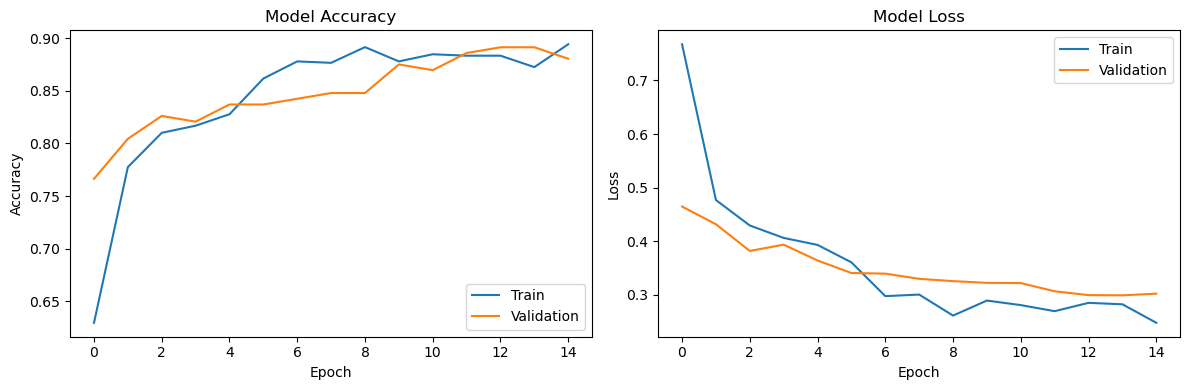

2025-04-28 14:21:46.026423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:46.028928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:46.057268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:46.101025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:46.116374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:46.137769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:46.172420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


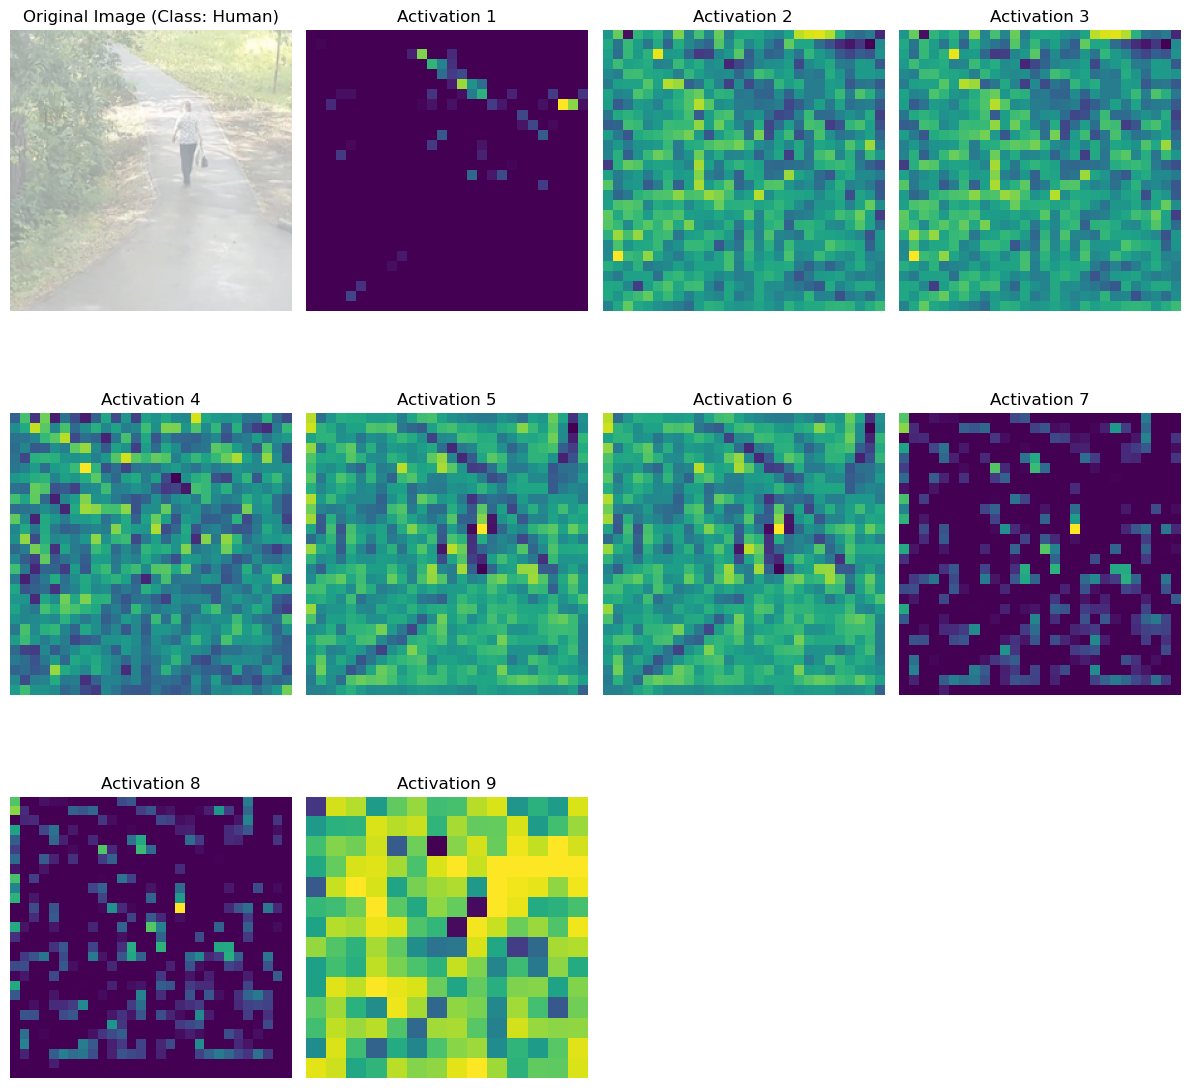

Evaluating the model...


2025-04-28 14:21:47.400166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:47.403585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:47.428410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:47.465292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:47.471519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:47.486596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:47.510731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


6/6 [==============================] - 1s 193ms/step - loss: 0.3022 - accuracy: 0.8804
Validation accuracy: 0.8804
Validation loss: 0.3022


2025-04-28 14:21:48.834967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:48.837958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:48.865018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:48.913697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:48.922293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:48.946385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-04-28 14:21:48.990000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


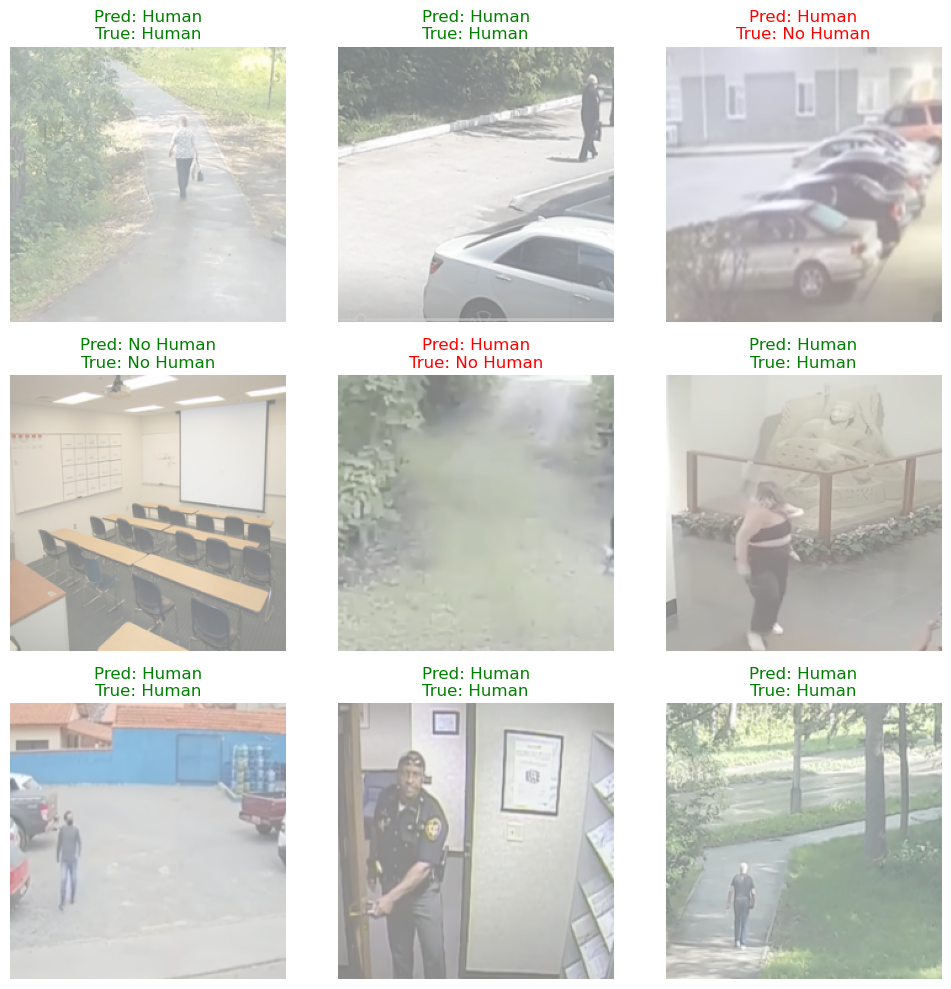

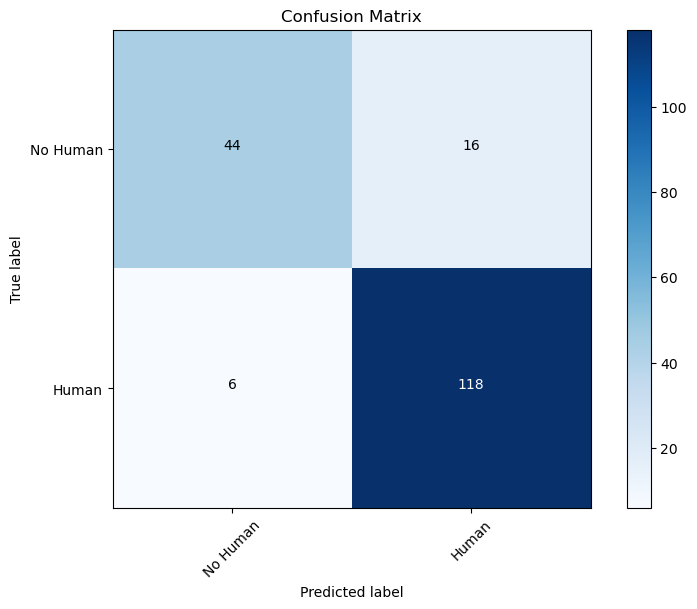


Classification Report:
              precision    recall  f1-score   support

    No Human       0.88      0.73      0.80        60
       Human       0.88      0.95      0.91       124

    accuracy                           0.88       184
   macro avg       0.88      0.84      0.86       184
weighted avg       0.88      0.88      0.88       184

Saving model for deployment...


2025-04-28 14:22:01.816036: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: mobilenetv2_human_detection_model/assets


/home/testtube_v/miniconda3/envs/raspi/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/testtube_v/miniconda3/envs/raspi/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: /tmp/tmpt3z3dhv2/assets


2025-04-28 14:22:44.012989: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2025-04-28 14:22:44.013053: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2025-04-28 14:22:44.014282: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpt3z3dhv2
2025-04-28 14:22:44.052094: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2025-04-28 14:22:44.052155: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/tmpt3z3dhv2
2025-04-28 14:22:44.241422: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2025-04-28 14:22:44.970409: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: /tmp/tmpt3z3dhv2
2025-04-28 14:22:45.318704: I tensorflow/cc/saved_model/loader.cc:283] SavedModel load for tags { serve }; Status: success: OK. Took 130443

INFO:tensorflow:Assets written to: /tmp/tmp4gkfn7az/assets


INFO:tensorflow:Assets written to: /tmp/tmp4gkfn7az/assets
2025-04-28 14:23:19.260437: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2025-04-28 14:23:19.260504: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2025-04-28 14:23:19.260805: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp4gkfn7az
2025-04-28 14:23:19.298581: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2025-04-28 14:23:19.298631: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/tmp4gkfn7az
2025-04-28 14:23:19.478685: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2025-04-28 14:23:20.202321: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: /tmp/tmp4gkfn7az
2025-04-28 14:23:20.513903: I tensorflow/cc/saved_model/loader.cc:283] SavedMode

Model saved for deployment.


In [7]:

def save_model_for_deployment(model):
    """Save the model for deployment."""
    print("Saving model for deployment...")
    
    # Save the entire model
    model.save('mobilenetv2_human_detection_model')
    
    # Save as TensorFlow Lite model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    
    with open('mobilenetv2_human_detection_model.tflite', 'wb') as f:
        f.write(tflite_model)
    
    # Create TFLite model with quantization for smaller size
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    tflite_fp16_model = converter.convert()
    
    with open('mobilenetv2_human_detection_model_quantized.tflite', 'wb') as f:
        f.write(tflite_fp16_model)
    
    print("Model saved for deployment.")

def create_inference_function(model):
    """Create a function for easy inference on new images."""
    def predict_human_in_image(image_path):
        # Read image file
        img = tf.io.read_file(image_path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        
        # Resize to target size
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        
        # Apply MobileNetV2 preprocessing
        img = preprocess_input(img)
        
        # Add batch dimension
        img = tf.expand_dims(img, 0)
        
        # Make prediction
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction, axis=1)[0]
        probability = prediction[0][predicted_class] * 100
        
        # Create result dictionary
        result = {
            'prediction': 'Human' if predicted_class == 1 else 'No Human',
            'probability': float(probability),
            'is_human': bool(predicted_class == 1)
        }
        
        # Display the image with prediction
        plt.figure(figsize=(6, 6))
        
        # Convert from preprocessing format back to display format
        display_img = img[0].numpy()
        display_img = ((display_img * 0.5) + 0.5) * 255  # Reverse preprocessing
        display_img = np.clip(display_img, 0, 255).astype('uint8')
        
        plt.imshow(display_img)
        plt.title(f"Prediction: {result['prediction']} ({result['probability']:.2f}%)")
        plt.axis('off')
        plt.show()
        
        return result
    
    return predict_human_in_image

def main():
    """Main function to run the complete pipeline."""
    
    # Build model
    model, base_model = build_mobilenetv2_model()
    model.summary()
    
    # Train model
    history_obj, history_dict = train_model(model, train_ds, val_ds, base_model)
    
    # Plot training history
    plot_training_history(history_dict)
    
    # Visualize activations
    visualize_activations(model, val_ds)
    
    # Evaluate model
    evaluate_model(model, val_ds)
    
    # Save model for deployment
    save_model_for_deployment(model)

    # Create and test inference function
    predict_human = create_inference_function(model)
    
    return predict_human

if __name__ == "__main__":
    predict_human = main()
    
    # Example of how to use the inference function (uncomment to test)
    # test_image = "./path/to/test/image.jpg"
    # if os.path.exists(test_image):
    #     result = predict_human(test_image)
    #     print(f"\nTest prediction on {test_image}:")
    #     print(f"Prediction: {result['prediction']}")
    #     print(f"Probability: {result['probability']:.2f}%")
    #     print(f"Is human present: {result['is_human']}")